In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import joblib as jb
import tifffile
from pathlib import Path
from glob import glob
import math
import cv2
import matplotlib.patches as mpatches
import colorsys

In [72]:
bands_path = '../data/bands/'
model_path = 'generated/models/'
mask_path = 'generated/masks/'
map_path = 'generated/maps/'

# load model

In [73]:
rf_model = jb.load(f'{model_path}model_rf.pkl.z')

# load rgb image

In [74]:
rgb_image = cv2.imread(f'{map_path}/rgb_image.jpg')

# load bands

In [75]:
bands_list = [e for e in glob(str(bands_path)+'/*')]
bands_list.sort()

In [76]:
bands_dict = {}
for i, e in enumerate(bands_list):
    bands_dict[f'b{i+1}'] = tifffile.TiffFile(e)

In [77]:
bands_arrays_dict = {}
for k, v in bands_dict.items():
    bands_arrays_dict[k] = v.asarray()

# load mask

In [78]:
ndwi_mask = cv2.imread(f'{mask_path}/ndwi38_03.jpg')

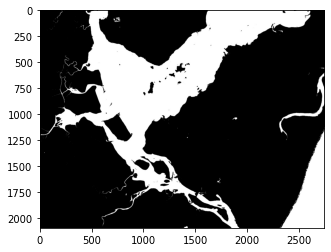

In [79]:
plt.imshow(ndwi_mask,'gray')

# create df of water region

In [80]:
# used features: b1 b5 b6 cspm(2950*b7^1.357)

In [81]:
aux = list()
for i in range(ndwi_mask.shape[0]):
    for j in range(ndwi_mask.shape[1]):
        if ndwi_mask[i][j][0] == 255:
            aux.append(np.array([j,i,bands_arrays_dict['b1'][i][j], bands_arrays_dict['b5'][i][j], bands_arrays_dict['b6'][i][j], 2950*pow(bands_arrays_dict['b7'][i][j],1.357)]))

In [82]:
dfaux = pd.DataFrame(aux)

In [83]:
dfaux.columns = ["x","y","b1","b5","b6","cspm"]

# prediction using model

In [84]:
z = rf_model.predict(dfaux.drop(["x","y"],axis=1))

In [85]:
dfaux['z'] = z

In [86]:
jb.dump(dfaux,'generated/dataframes/prediction.pkl.z')

['generated/dataframes/prediction.pkl.z']

# depth image

In [87]:
max_depth_value = 30

In [88]:
output = rgb_image.copy()
for i, row in enumerate(dfaux.itertuples()):
    x = int(row[1])
    y = int(row[2])
    z = row[-1]
    output[y][x] = [int(e*255) for e in (colorsys.hls_to_rgb(z/float(max_depth_value), 0.5, 1))]

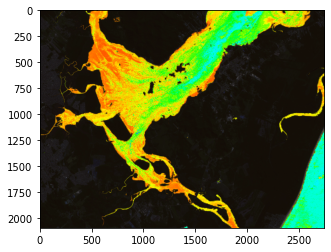

In [89]:
plt.imshow(output)

In [90]:
output = cv2.cvtColor(output,cv2.COLOR_BGR2RGB)

# label

In [91]:
frame = output.copy()
posx = 0.80
posy = 0.5
height = 0.4
width = 0.15
minDepth = 0
maxDepth = 30
spacing = 5
intervals = int((maxDepth - minDepth)/spacing) + 1

h = int(output.shape[0]*height)
w = int(output.shape[1]*width)
x = int(output.shape[1]*posx)
print(x)
y = int(output.shape[0]*posy)
cv2.rectangle(frame, (x, y), (x+w,y+h), (255, 255, 255), -1)

cv2.rectangle(frame, (x, y-300), (x+w,y), (255, 255, 255), -1)


font = cv2.FONT_HERSHEY_COMPLEX
fontScale = 3
color = (0, 0, 0)
thickness = 4
pos = (x+50, y-180)
cv2.putText(frame, "Depth", pos, font, fontScale, color, thickness, cv2.LINE_AA)
pos = (x+50, y-40)
fontScale = 2
cv2.putText(frame, "(meters)", pos, font, fontScale, color, thickness, cv2.LINE_AA)

fontScale = 2
for i in range(intervals):
    pos = (x+250, y+65+int(i*h/intervals))
    cv2.putText(frame, str(i*spacing), pos, font, fontScale, color, thickness, cv2.LINE_AA)

iterations = int(maxDepth-minDepth)*100
for i in range(iterations):
    color = [int(e*255) for e in (colorsys.hls_to_rgb(((i)/100)/max_depth_value, 0.5, 1))]
    cv2.rectangle(frame, (x+50, y+int(0.96*h*(i/iterations))), (x+int(w/2.5),y+int(0.96*h*(i/iterations))+1), color[::-1], -1)
    

2193


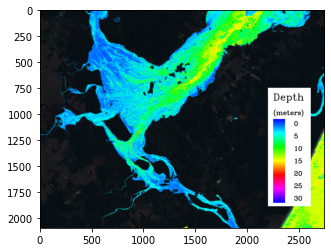

In [92]:
plt.imshow(frame)

In [93]:
cv2.imwrite(f'{map_path}/depth_map.jpg',frame)

True